# Contextualização e Descrição do Problema
Neste projeto, utilizamos Python e o framework PyTorch para implementar uma rede neural convolucional (CNN) simples, com o objetivo de realizar a classificação de imagens. O foco é desenvolver um modelo que atinja alto desempenho. Para isso, exploramos a influência de diversos hiperparâmetros (número de camadas, filtros, tamanhos de kernel, método de pooling, normalização, algoritmo de treinamento, etc.) e buscamos a configuração ideal utilizando a ferramenta de otimização Optuna, juntamente com a tecnica de pruner que o Optuna possue. 

# Importação de Bibliotecas e Configurações
Importar as bibliotecas necessárias, configurar o ambiente do PyTorch e definir seeds para reprodutibilidade. Incluir a importação do PyTorch, PyTorch Lightning, Optuna e outras dependências relevantes.

In [1]:
# Importação das bibliotecas principais
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import lightning.pytorch as pl
import optuna
import numpy as np
import random
from optuna.integration import PyTorchLightningPruningCallback
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from lightning.pytorch.loggers import TensorBoardLogger
import os

torch.cuda.synchronize()

# Configuração de seeds para reprodutibilidade
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
pl.seed_everything(SEED, workers=True)

# Configurações para melhorar a performance
torch.set_float32_matmul_precision("high")
torch.backends.cudnn.benchmark = True
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

Seed set to 42


0
0


# Descrição do Conjunto de Dados Utilizado
O conjunto de dados escolhido foi o **CIFAR-10**, que contém 40.000 imagens de treinamento, 10.000 de validação e 10.000 imagens de teste, distribuídas em 10 classes diferentes (como *airplane*, *automobile*, *bird*, *cat*, *deer*, *dog*, *frog*, *horse*, *ship* e *truck*). Além disso, foi realizado um split adicional do conjunto de treinamento para criação de um conjunto de validação.

# Métodos de Pré-processamento
Para padronizar os dados, as imagens foram:
- Convertidas para tensores.
- Normalizadas com média e desvio padrão apropriados para deslocá-las para o intervalo [-1, 1].

Essas transformações, implementadas com `torchvision.transforms.Compose`, são essenciais para acelerar o treinamento e melhorar a convergência do modelo.

Exemplo de imagens do dataset CIFAR10 com seus rótulos:


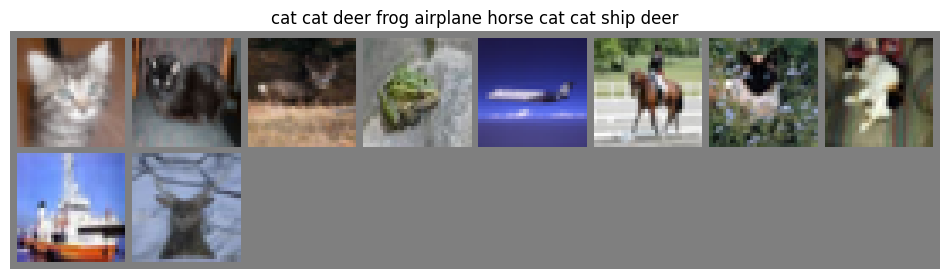

Classes do dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Tamanho do conjunto de treinamento: 40000
Tamanho do conjunto de validação: 10000
Tamanho do conjunto de teste: 10000


In [2]:
# Carregamento do dataset CIFAR10
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        ),  # Normalização para [-1, 1]
    ]
)

# Carregar o dataset com as transformações
dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

# Definir tamanhos para treino e validação
train_size = int(0.8 * len(dataset))  # 80% para treino
val_size = len(dataset) - train_size  # 20% para validação
generator = torch.Generator().manual_seed(42)
# Dividir o dataset em treino e validação
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator)

# Criação dos DataLoaders para um i7-12700F, 32GB de RAM e RTX 3060
train_loader = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=10,
    pin_memory=True,
    persistent_workers=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=10,
    pin_memory=True,
    persistent_workers=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=512, shuffle=False, num_workers=10, pin_memory=True
)

classes = dataset.classes


# Função para exibir imagens com seus rótulos
def imshow_with_labels(img, labels):
    img = img / 2 + 0.5  # Desfaz a normalização
    npimg = img.numpy()
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.title(" ".join(classes[label] for label in labels))
    plt.show()


# Obtendo um batch de imagens do DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Exibindo algumas imagens do dataset com seus rótulos
print("Exemplo de imagens do dataset CIFAR10 com seus rótulos:")
imshow_with_labels(torchvision.utils.make_grid(images[:10]), labels[:10])

# Exibição de estatísticas básicas do dataset
print(f"Classes do dataset: {classes}")
print(f"Tamanho do conjunto de treinamento: {len(train_dataset)}")
print(f"Tamanho do conjunto de validação: {len(val_dataset)}")
print(f"Tamanho do conjunto de teste: {len(test_dataset)}")

# Descrição do Modelo Implementado
O modelo consiste em:
- Uma sequência de camadas convolucionais (com opção de Batch Normalization) seguida de uma camada de pooling (MaxPool ou AvgPool).
- Camadas totalmente conectadas (FC) dispostas após o flatten da saída da parte convolucional.

Os hiperparâmetros (como número de camadas, tamanhos dos filtros, kernel_size, dropout_rate, tipo de ativação, otimizador, scheduler, entre outros) foram ajustados utilizando **Optuna** e o pruner Hyperband

In [ ]:
def get_activation_function(name):
    # Função para obter a função de ativação desejada
    activations = {
        "relu": nn.ReLU(),
        "leaky_relu": nn.LeakyReLU(0.1),
        "silu": nn.SiLU(),
    }
    return activations[name]


def get_conv(input, output, kernel_size, batch_norm=False):
    # Retorna uma camada convolucional opcionalmente com BatchNorm
    if batch_norm:
        return nn.Sequential(
            nn.Conv2d(input, output, kernel_size),
            nn.BatchNorm2d(output),
        )
    else:
        return nn.Conv2d(input, output, kernel_size)


def get_conv_list(list_size, kernel_size, activation, batch_norm=False):
    # Cria uma sequência de camadas convolucionais
    convs = []
    for i in range(len(list_size) - 1):
        convs.append(get_conv(list_size[i], list_size[i + 1], kernel_size, batch_norm))
        convs.append(activation)
    return nn.Sequential(*convs)


def get_fc_list(list_size, activation, dropout_rate=0.0):
    # Cria uma sequência de camadas totalmente conectadas
    layers = []
    for i in range(len(list_size) - 1):
        layers.append(nn.Linear(list_size[i], list_size[i + 1]))
        layers.append(activation)
        if dropout_rate > 0.0:
            layers.append(nn.Dropout(dropout_rate))
    return nn.Sequential(*layers)


class CNNModel(pl.LightningModule):
    def __init__(
        self,
        list_size,
        kernel_size,
        pool_type,
        dropout_rate,
        taxa,
        fc_list,
        activation,
        optimizer_type,
        scheduler_type,
        batch_norm,
        weight_decay,
        weight_decay_ter,
        scheduler_param,
        input_size=(3, 32, 32),
        num_classes=10,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["input_size"])
        self.taxa = taxa
        self.scheduler_type = scheduler_type
        self.optimizer_type = optimizer_type
        self.activation = get_activation_function(activation)
        self.pool = nn.MaxPool2d(2, 2) if pool_type == "max" else nn.AvgPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.conv = get_conv_list(
            [input_size[0]] + list_size, kernel_size, self.activation, batch_norm
        )

        self.criterion = nn.CrossEntropyLoss()
        self.weight_decay = weight_decay if weight_decay_ter else 0

        # Calcula o tamanho da entrada para as camadas totalmente conectadas
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size).to(
                memory_format=torch.channels_last
            )
            x = self.conv(dummy_input)
            x = self.pool(x)
            flattened_dim = torch.flatten(x, 1).size(1)

        fc_list = [flattened_dim] + fc_list + [num_classes]
        self.fc = get_fc_list(fc_list, self.activation, dropout_rate)
        self.scheduler_param = scheduler_param

    def forward(self, x):
        # Propagação direta do modelo
        x = self.conv(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        # Etapa de treinamento
        images, labels = batch
        outputs = self(images.to(memory_format=torch.channels_last))
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # Etapa de validação
        images, labels = batch
        outputs = self(images.to(memory_format=torch.channels_last))
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def on_train_epoch_start(self):
        # Obtém o learning rate do otimizador
        lr = self.trainer.optimizers[0].param_groups[0]["lr"]
        self.log("learning_rate", lr, prog_bar=True, on_epoch=True)

    def configure_optimizers(self):
        # Configuração do otimizador e scheduler de aprendizado
        optimizers = {
            "adam": optim.Adam(
                self.parameters(), lr=self.taxa, weight_decay=self.weight_decay
            ),
            "adamw": optim.AdamW(
                self.parameters(), lr=self.taxa, weight_decay=self.weight_decay
            ),
        }
        optimizer = optimizers[self.optimizer_type]

        if self.scheduler_type == "none":
            return optimizer
        else:
            schedulers = {
                "cosine": optim.lr_scheduler.CosineAnnealingLR,
                "onecycle": optim.lr_scheduler.OneCycleLR,
                "exponential": optim.lr_scheduler.ExponentialLR,
            }
            scheduler = schedulers[self.scheduler_type](
                optimizer, **self.scheduler_param
            )
            return [optimizer], [scheduler]


# Função de otimização com Optuna
def objective(trial):
    # Define os hiperparâmetros a serem ajustados
    list_size = []
    num_conv = trial.suggest_int("num_conv", 1, 3)
    for i in range(num_conv):
        list_size.append(trial.suggest_int(f"size_conv_{i}", 16, 64, step=8))
    fc_list = []
    num_fc = trial.suggest_int("num_fc", 1, 3)
    for i in range(num_fc):
        fc_list.append(trial.suggest_int(f"size_fc_{i}", 16, 64, step=8))
    kernel_size = trial.suggest_int("kernel_size", 3, 5)
    pool_type = trial.suggest_categorical("pool_type", ["max", "avg"])
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    taxa = trial.suggest_float("taxa", 1e-4, 1e-2, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "silu"])
    optimizer_type = trial.suggest_categorical("optimizer_type", ["adam", "adamw"])
    scheduler_type = trial.suggest_categorical(
        "scheduler_type", ["cosine", "onecycle", "exponential", "none"]
    )
    if scheduler_type == "onecycle":
        scheduler_param = {
            "max_lr": trial.suggest_float("max_lr", 1e-3, 1e-1, log=True),
            "steps_per_epoch": trial.suggest_int("steps_per_epoch", 100, 500, step=50),
            "epochs": trial.suggest_int("epochs", 10, 100, step=10),
        }
    elif scheduler_type == "cosine":
        scheduler_param = {
            "T_max": trial.suggest_int("T_max", 5, 50, step=5),
        }
    elif scheduler_type == "exponential":
        scheduler_param = {
            "gamma": trial.suggest_float("gamma", 0.2, 0.99, log=True),
        }
    else:
        scheduler_param = {}
    batch_norm = trial.suggest_categorical("batch_norm", [True, False])
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-2)
    weight_decay_ter = trial.suggest_categorical("weight_decay_ter", [True, False])

    # Cria o modelo com os hiperparâmetros sugeridos
    model = CNNModel(
        list_size=list_size,
        kernel_size=kernel_size,
        pool_type=pool_type,
        dropout_rate=dropout_rate,
        taxa=taxa,
        fc_list=fc_list,
        activation=activation,
        optimizer_type=optimizer_type,
        scheduler_type=scheduler_type,
        batch_norm=batch_norm,
        weight_decay=weight_decay,
        weight_decay_ter=weight_decay_ter,
        scheduler_param=scheduler_param,
    )
    model = model.to(memory_format=torch.channels_last)
    # model = torch.compile(model)
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath="optuna_checkpoints",
        filename=f"trial_{trial.number}_best",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        every_n_epochs=5,
    )

    trainer = pl.Trainer(
        max_epochs=50,
        logger=TensorBoardLogger("lightning_logs", name="optuna_cnn"),
        callbacks=[
            checkpoint_callback,
            PyTorchLightningPruningCallback(trial, monitor="val_loss"),
        ],
        check_val_every_n_epoch=2,
        precision="16-mixed",
        # enable_progress_bar=False,
    )
    trainer.fit(model, train_loader, val_loader)
    torch.cuda.synchronize()

    # Caminho absoluto
    caminho_absoluto = checkpoint_callback.best_model_path

    # Caminho relativo baseado no diretório atual
    caminho_relativo = os.path.relpath(caminho_absoluto, start=os.getcwd())

    # Definir o caminho relativo como atributo do usuário
    trial.set_user_attr("checkpoint_path", caminho_relativo)
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_reserved())

    return checkpoint_callback.best_model_score.item()


# Executa a otimização com Optuna
pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=50)
study = optuna.create_study(
    pruner=pruner,
    study_name="CNN_otimizacao",
    storage="sqlite:///CNN_otimizacao.db",
    direction="minimize",
    load_if_exists=True,
)
study.optimize(objective, n_trials=200 - len(study.trials))
print("Melhor loss:", study.best_value)
# Exibe os melhores parâmetros do melhor modelo
print("Hiperparâmetros do melhor modelo:")
best_trial = study.best_trial
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

[I 2025-03-20 20:22:34,933] Using an existing study with name 'CNN_otimizacao' instead of creating a new one.


Melhor loss: 0.7793696522712708
Hiperparâmetros do melhor modelo:
num_conv: 3
size_conv_0: 32
size_conv_1: 56
size_conv_2: 32
num_fc: 2
size_fc_0: 64
size_fc_1: 64
kernel_size: 4
pool_type: avg
dropout_rate: 0.32300059993737856
taxa: 0.0014975173020646839
activation: leaky_relu
optimizer_type: adam
scheduler_type: cosine
T_max: 40
batch_norm: True
weight_decay: 0.007982460399316237
weight_decay_ter: False


# Avaliação dos Resultados e Discussão dos Hiperparâmetros
Após o treinamento, o desempenho do modelo foi avaliado no conjunto de teste através das métricas de *loss* e *acurácia*.  
Adicionalmente, foram gerados gráficos de:
- Importância dos hiperparâmetros.
- Histórico de otimização.
- Matriz de confusão (verdadeiro vs. predito).

Essas análises contribuem para entender a influência de cada hiperparâmetro e identificar possíveis trade-offs entre a complexidade do modelo e seu desempenho.

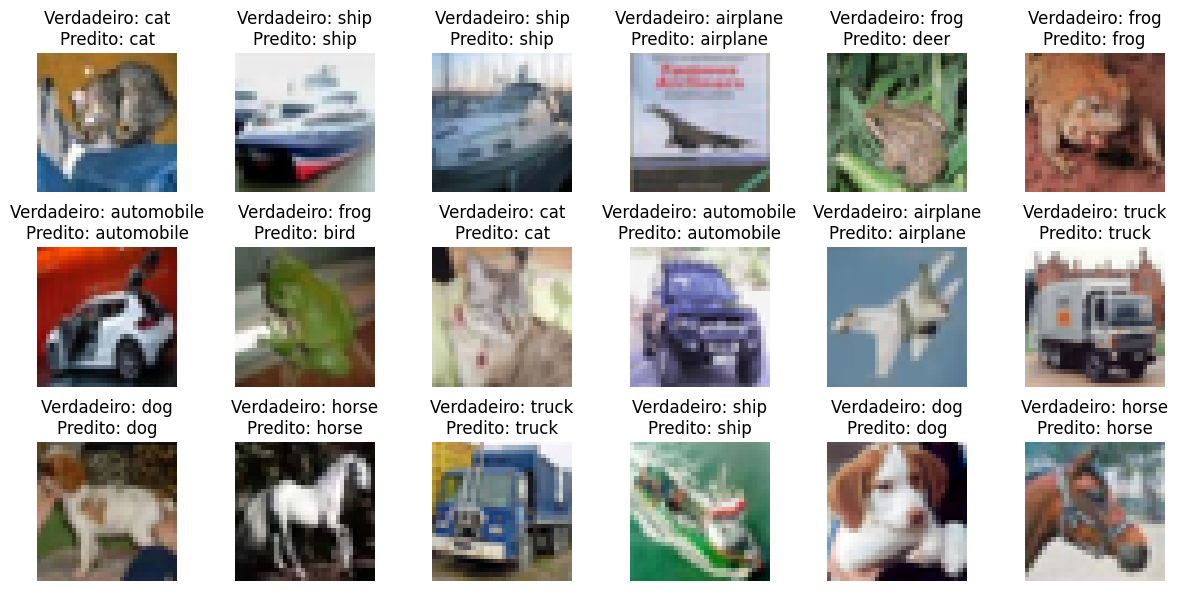

In [4]:
# Carrega o melhor modelo a partir do checkpoint salvo durante a otimização
best_checkpoint = best_trial.user_attrs["checkpoint_path"]
final_model = CNNModel.load_from_checkpoint(best_checkpoint)

final_model.eval()
# Pegue um lote de imagens e labels do test_loader
images, labels = next(iter(test_loader))
images = images.to("cuda")
labels = labels.to("cuda")
with torch.no_grad():
    outputs = final_model(images)
    _, preds = outputs.max(1)


# Função para desfazer a normalização e exibir corretamente a imagem
def unnormalize(img):
    return img * 0.5 + 0.5


# Plota as primeiras 18 imagens com os rótulos verdadeiros e preditos
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
for idx, ax in enumerate(axes.ravel()):
    if idx >= len(images):
        break
    img = unnormalize(images[idx]).cpu().permute(1, 2, 0).numpy()
    true_label = classes[labels[idx]]
    pred_label = classes[preds[idx]]
    ax.imshow(img)
    ax.set_title(f"Verdadeiro: {true_label}\nPredito: {pred_label}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [5]:
from optuna.visualization import (
    plot_param_importances,
    plot_optimization_history,
    plot_intermediate_values,
)

# Gráfico de importância dos hiperparâmetros
fig_importance = plot_param_importances(study)
fig_importance.show()

# Gráfico de histórico de otimização (loss por tempo)
fig_optimization_history = plot_optimization_history(study)
fig_optimization_history.show()

# Gráfico de histórico de loss (loss por tempo)
fig_intermediate_values = plot_intermediate_values(study)
fig_intermediate_values.show()

In [6]:
# Avaliação do desempenho no conjunto de teste
final_model.eval()
total_loss = 0.0
correct = 0
total = 0

criterion = nn.CrossEntropyLoss()

all_labels = torch.tensor([], dtype=torch.long, device="cuda")
all_outputs = torch.tensor([], device="cuda")
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = final_model(images)
        all_labels = torch.cat((all_labels, labels))
        all_outputs = torch.cat((all_outputs, outputs))

# Calcula o loss total e a acurácia para all_labels e all_outputs
final_loss = criterion(all_outputs, all_labels).item()
final_preds = all_outputs.argmax(dim=1)
final_acc = (final_preds == all_labels).float().mean().item()

print(f"Loss total calculado: {final_loss:.4f}")
print(f"Acurácia total calculada: {final_acc:.4f}")

Loss total calculado: 0.7939
Acurácia total calculada: 0.7507


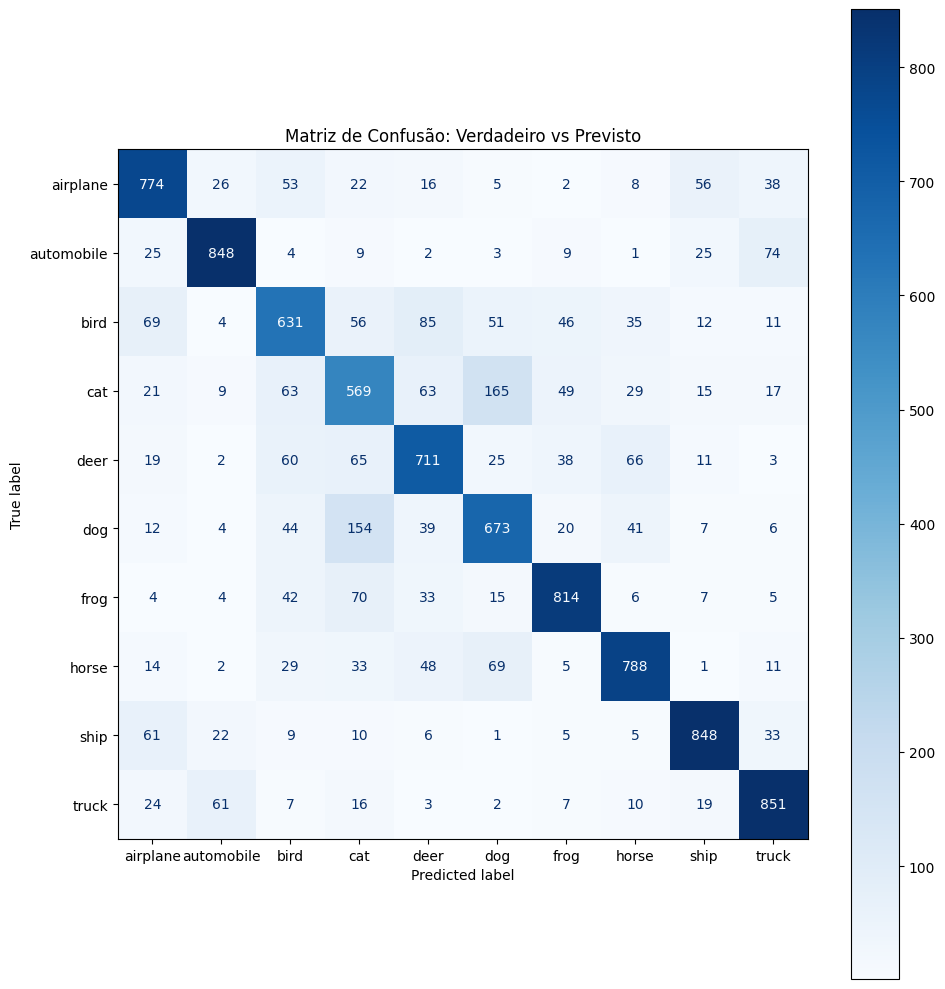

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_outputs = all_outputs.argmax(dim=1).cpu()
all_labels = all_labels.cpu()


conf_matrix = confusion_matrix(all_labels, all_outputs)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Matriz de Confusão: Verdadeiro vs Previsto")
plt.tight_layout()
plt.show()

# Conclusão

Após a realização de uma série de experimentos e a otimização dos hiperparâmetros utilizando o framework **Optuna**, o modelo de **Rede Neural Convolucional (CNN)** apresentou um desempenho consistente e satisfatório na tarefa de classificação de imagens do conjunto de dados **CIFAR-10**. Apesar de sua arquitetura relativamente simples e do número reduzido de parâmetros, o modelo alcançou uma acurácia final de **75,07%** no conjunto de teste, com um *loss* de **0,7939**, demonstrando boa capacidade de generalização.

Os resultados obtidos evidenciam a importância de uma abordagem sistemática para a modelagem e otimização de redes neurais. A utilização de técnicas avançadas, como o ajuste de hiperparâmetros com **Optuna** e o uso de *pruners* para descartar configurações subótimas, foi essencial para explorar de forma eficiente o espaço de busca e identificar configurações que maximizassem o desempenho do modelo.

Adicionalmente, a análise da importância dos hiperparâmetros revelou insights valiosos sobre os fatores que mais influenciam o desempenho do modelo, permitindo uma compreensão mais profunda das interações entre os componentes da arquitetura e os parâmetros de treinamento.